# Teleseismic *P*-wave coda autocorrelation

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeis-VNU/blob/master/Day4/D4_Lab.ipynb)

Thanh-Son Pham (ThanhSon.Pham@anu.edu.au) 

- October 2017: First release on [GitHub](https://github.com/tsonpham/PCodaAutocorrelation.git).
- March 2025: Revision for Observational Seismology Workshop at VNU Hanoi University of Science.

This notebook implements a lightweight version of the *P wave coda autocorrelation* method in the Python programing language. The method is demonstrated with seismic data acquired by station [YT ST01](https://ds.iris.edu/mda/YT/ST01/?starttime=2010-01-27T00:00:00&endtime=2012-12-31T23:59:59) operating from 2010 to 2012 over the ~3 km thick icesheet in West Antarctica.

For more details, we refer to the following articles:
- Phạm T.-S. and H. Tkalčić, *On the feasibility and use of teleseismic P-wave coda autocorrelation for mapping shallow seismic discontinuities*, J. Geophys. Res.: Solid Earth, 122, doi:10.1002/2017JB013975, **2017**.
- Phạm T.-S. and H. Tkalčić, *Antarctic ice properties revealed from teleseismic P wave coda autocorrelation*, J. Geophys. Res.: Solid Earth, 123, doi:10.1029/2018JB016115, **2018**.

--- 
## What we do in this notebook
Here we demonstrate the *P-wave coda autocorrelation method* to image the ice-bedrock interface beneath the Antarctic ice sheet using single-component seismograms. Specific tasks include:
* Retrieve automatically waveforms of a seismic phase from the IRIS data server,
* Perform pre-processing on retrieved waveforms,
* Compute the autocorrelation function of time series,
* Apply bandpass filter to the computed autocorrelograms,
* Interprete the autocorrelogram in the glacial context.

In [1]:
# Environemtal setup (uncomment if running in colab)

# !pip install -U obspy basemap

---
### Overview

The autocorrelation method include two major steps.

**STEP 1**

As sumarised in the figure below, an individidual P-wave coda record is transformed into the frequency domain. The spectrum is balanced, or whitened, using an adaptive weighting trace. The autocorrelation is computed by squaring the whitened spectrum, then inversely tranformed to the time domain (figure below).

<div>
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/5fab2346-82da-41a5-a4b9-68965dee2cea/jgrb52088-fig-0004-m.jpg" width="400"/>
</div>
(Source: Phạm & Tkalčić, 2017, JGR)

**STEP 2**

Autorrelograms of teleseismic earthquakes to the same station are stacked, or summed up, to improve the signal to noise ratio of the stacked autocorrelogram. We use linear stacking (DLS) or phase weighted stacking (PWS) methods to complement the interpretation.

<div>
<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/389caf59-989c-424a-81be-74a6e6d13350/jgrb53027-fig-0002-m.jpg" width="400"/>
</div>
(Source: Phạm & Tkalčić, 2018, JGR)

### Spectral normalization
We use an adaptive weighting function to normalize the complex spectrum of the input waveform before computing the autocorrelation function. The spectral whitening is defined in a similar way to the running-absolute-mean normalization [Bensen et al., 2007] in the time domain as

\begin{equation}
\hat{s}_n = \frac{s_n} {\frac{1}{2N + 1} \sum_{j=n-N}^{n+N} |s_j|}.
\end{equation}

The number of averaging points $N$ in the denominator is alternatively refered as spectral whitening width $\Delta W = 2 N \Delta \omega$, where $\Delta \omega$ is the discrete frequency step $\Delta \omega = 1/L$ and $L$ is the length of the input time trace. Tuning the whitening width $\Delta W$ may change the performance of the method. We recommend to do experiments with this parameter to find an optimal value for your application.

In [2]:
import numpy as np
from scipy.signal import fftconvolve, hilbert

def smooth_avg(arr, winlen):
    """
    Smoothing a time series by averaging its values in a moving window. This averaging 
    window operation can be done efficiently with an convolution in the frequency domain.
    """

    window = np.ones(winlen) / (1.0 * winlen)
    return fftconvolve(arr, window, 'same')

def spectral_whitening(arr, delta, freq_width, npts=None, returnweight=False):
    """
    Frequency whitening of a time series by balancing its spectrum by smoothed absolute
    array of the spectrum.
    
    arr        : input seismogram
    delta      : sampling time step of the input
    freq_width : spectral whitening width
    returnweith: return the averaging width or not
    """
    npts = len(arr) if npts is None else npts
    carr = np.fft.fftshift(np.fft.fft(arr, 2 * npts))

    Nyfreq = 0.5 / delta
    spec_step = Nyfreq / npts
    if freq_width != None:
        winlen = int(0.5 * freq_width / spec_step) * 2 + 1
        weight = smooth_avg(np.abs(carr), winlen)
        if any(weight < 1e-8): raise Exception('Zero division')
        
        carr /= weight
        carr[weight<1e-6*np.max(weight)] = 0

    if returnweight:
        return carr[npts-1:2*npts], weight[npts-1:2*npts]
    else:
        return carr[npts-1:2*npts]

### Autocorrelation
The autocorrelation of a time trace is the inverse transform of the whitend power spectrum. 
$$
a_n(\omega) = |\hat{s}_n|^2
$$
The discrete spectrum of the autocorrelation in the frequemcy domain, $a_n(\omega)$ is inverse Fourier transformed to the time domain.

The only causal part of the autocorrelation trace is retained. We use a cosine taper to the central peak and bandpass in the frequency band 1-5 Hz. 

In [3]:
def compute_auto(tr, freq_width, npts=None,
                 filter_kwargs={'freqmin':1.0, 'freqmax':5.0, 'corners':4, 'zerophase':True},
                 taper_width=0.5):
    """
    Computing the autocorrelation function of the whitened trace.
    
    tr: input data seismogram
    freq_width: spectral whitening width
    npts: number of points for the autocorrelation
    filter_kwargs: filtering parameters
    taper_width: tapering width in seconds
    """
    npts = tr.stats.npts if npts is None else npts
    ## whitening and autocorrelating
    spectrum = spectral_whitening(tr.data, tr.stats.delta, freq_width, npts)
    ## autocorrelating
    tr.data = np.fft.irfft(np.abs(spectrum)**2)[0:npts]
    
    # post processing: tapering and filtering
    taper_frac = taper_width / (npts * tr.stats.delta)
    tr.taper(type='cosine', max_percentage=taper_frac)
    tr.filter('bandpass', **filter_kwargs)
    tr.taper(type='cosine', max_percentage=taper_frac)

    return tr

### Phase weighted stacking

*Phase-weighted stacking* is a nonlinear stacking technique to sufficiently enhance coherent signals and suppress noise [Schimmel and Paulssen, 1997]. It uses the averaging phase of the input traces to weight the linear stack of the input.

The analytical signals of a one-sided autocorrelogram $s_n$ is given by
$$
S_n(t) = s_n(t) + i H_n(t) = A_n(t) e^{i\Phi_n(t)}
$$
where $H_n(t)$ is the Hilbert transform of the original trace $s_n(t)$. And, $A_n(t)$, $\Phi_n(t)$ are the amplitude and phase components of the analytic signal. The phase-weighted stack of $N$ input traces is defined as
$$
g(t) = \frac{1}{N} \sum_{n=1}^N s_n(t) \; \left|\frac{1}{N}\sum_{n=1}^N e^{i\Phi_n(t)}\right|^\eta.
$$
The order $\eta$ is used to adjust the importance of the phase weighting factor. When $\eta = 0$, the 0th order phase-weighted stack becomes a linear stack.

In [4]:
from obspy.core import Trace

def data_stack(stream, order):
    """
    Phase weighted stacking
    
    stream: input stream of one-sided autocorrelograms
    order : order of the weight phase
    """
    stack = 0
    phase = 0j
    
    if order == 0:
        stack = np.sum([acorr.data for acorr in stream], axis=0)
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack)
    
    for acorr in stream:
        stack += acorr.data

        ## calculate phase
        asig = hilbert(acorr.data)
        phase += asig / np.abs(asig)

    stack /= len(stream)
    weight = np.abs(phase / len(stream))

    return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack * weight**order)

---
### Application for pilot station ST01 (West Antarctica)

This section contains step-by-step guide to acquire seismic data from remote server, perform processing, visualise data, and make initial interpretation of the results in the geological context.

#### Data preparation

First, we query the geographical location of station ST01 from IRIS Data Management center using an `obspy fdsn client`.

In [5]:
from obspy.clients.fdsn import Client
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

## definte the IRIS client
iris = Client('IRIS')
## name a station in Antarctica
stacode = 'ST01'
## get station information
inv = iris.get_stations(network='_ANTARCTICA', station=stacode, channel='?HZ', level='channel')
## some station names are reused for diffent temporary network campaigns
print (inv)

Inventory created at 2025-03-25T22:16:54.891900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?network=_ANTARCTICA&...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (1):
			YT.ST01 (ST01)
		Channels (2):
			YT.ST01..BHZ, YT.ST01..LHZ


Now, plot the station map for sanity check.

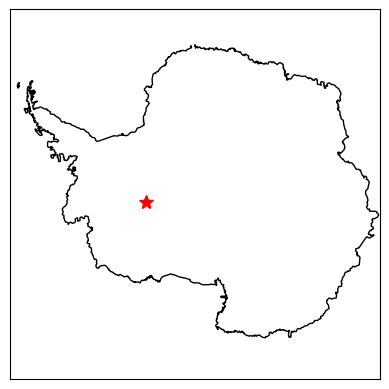

In [6]:
# define the plotting function
def plot_station_map(inv):
    """
    Plotting the station location from the inventory in the Antarctic map.
    """
    m = Basemap(projection='spstere', boundinglat=-65, lon_0=180, resolution='l')
    m.drawcoastlines()
    for net in inv:
        for sta in net:
            m.plot(sta.longitude, sta.latitude, 'r*', markersize=10, latlon=True)
    plt.show()
# call the function to plot map
plot_station_map(inv)

Second, search for all catalogued earthquakes of magnitude Mw 6.0+, between distances from 30 to 95° from the seismic station of interest, and download data for the events. 

In [7]:
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
from obspy import Catalog
taup_model = TauPyModel(model='ak135')

def download_data(inv, min_magnitude=6.0, min_radius=30, max_radius=95, 
        sample_rate=40, phase = 'P', before=10, after=50,
        cha_priorities=['BHZ', 'HHZ'], loc_priorities=['', '00', '10'],
        minlength=0.95, bulk_size=100):
    '''
    Download the waveform data from IRIS DMC for the given station inventory.

    This function helps to deal with some complicated situations for example, 
    when same station name is used in two networksthe catalogues are concatenated 
    to access the full data availability
    '''
    bulk_list = []
    metadata = []
    ## get the event catalog in the desired distance range during the station operation
    for net in inv:
        for sta in net:
            ## get the chanel code from the priority list
            for chacode in cha_priorities:
                if chacode in [cha.code for cha in sta]: break
            if chacode not in [cha.code for cha in sta]: continue
            ## get the location code from the priority list given the channel code
            for loccode in loc_priorities:
                if loccode in [cha.location_code for cha in sta if cha.code == chacode]: break
            if loccode not in [cha.location_code for cha in sta if cha.code == chacode]: continue
            ## get the event catalog in the desired distance range during the station operation
            cat = iris.get_events(starttime=sta.start_date, endtime=sta.end_date, 
                latitude=sta.latitude, longitude=sta.longitude,
                minradius=min_radius, maxradius=max_radius, minmagnitude=min_magnitude) 
            ## create a list to store the bulk information
            for event in cat:
                org = event.preferred_origin()
                ## calculate distance, azimuth, and back-azimuth
                dist, az, baz = gps2dist_azimuth(org.latitude, org.longitude, sta.latitude, sta.longitude)
                ## calculate the P-wave arrival time from the event to the station
                p_arv = taup_model.get_travel_times_geo(org.depth/1e3, org.latitude, org.longitude, 
                                                        sta.latitude, sta.longitude, [phase])[0]
                p_arv_time = org.time + p_arv.time
                ## enclose the calculated information into list
                bulk_list.append((net.code, sta.code, loccode, chacode, p_arv_time-before, p_arv_time+after))
                metadata.append({'dist': dist/1e3, 'az': az, 'baz': baz, 'p_atime': p_arv_time,
                                 'evla': org.latitude, 'evlo': org.longitude, 'evmag': event.magnitudes[0].mag,
                                 'evdp': org.depth/1e3, 'stla': sta.latitude, 'stlo': sta.longitude})
    ## query the waveform data from server
    if bulk_size is None or bulk_size>len(bulk_list): 
        dstream = iris.get_waveforms_bulk(bulk=bulk_list, threaded=True, minimumlength=minlength*(before+after))
    else:
        idx = np.random.choice(len(bulk_list), bulk_size, False)
        dstream = iris.get_waveforms_bulk(bulk=[bulk_list[_] for _ in idx], threaded=True, 
                                          minimumlength=minlength*(before+after))
    ## associate retieved waveforms with the event information
    p_atimes = np.array([_['p_atime'] for _ in metadata])
    for tr in dstream:
        idx = np.where(np.logical_and(p_atimes < tr.stats.endtime, p_atimes > tr.stats.starttime))[0]
        if len(idx) == 0: 
            dstream.remove(tr)
        else:
            tr.stats.update(metadata[idx[0]])
    ## resample the data to 40 Hz (if necessary) and remove the linear data trend
    dstream.resample(sample_rate)
    dstream.detrend('linear')
    return dstream

## evaluate the function to download the data
dstream = download_data(inv, bulk_size=100)
print (dstream)

37 Trace(s) in Stream:

YT.ST01..BHZ | 2010-02-01T22:40:43.099998Z - 2010-02-01T22:41:43.074998Z | 40.0 Hz, 2400 samples
...
(35 other traces)
...
YT.ST01..BHZ | 2011-01-17T19:33:47.874998Z - 2011-01-17T19:34:47.849998Z | 40.0 Hz, 2400 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


Let's plot the event map to see where they are!

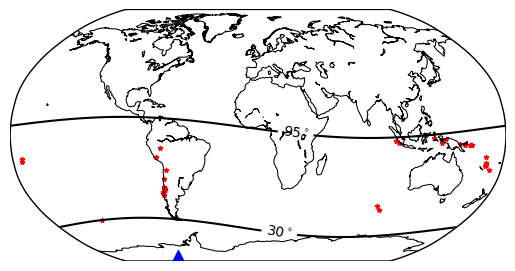

In [8]:
## plot the event location on a global map
m = Basemap(projection='robin', lon_0=0, resolution='c')
m.drawcoastlines(linewidth=.75)
## plot event location by red stars
evla = [tr.stats.evla for tr in dstream.select(component='Z')]
evlo = [tr.stats.evlo for tr in dstream.select(component='Z')]
m.scatter(evlo, evla, latlon=True, s=10, c='r', marker='*')
## plot the station location by blue triangle
stla, stlo = dstream[0].stats.stla, dstream[0].stats.stlo
m.plot(stlo, stla, 'b^', markersize=10, latlon=True)
## plot the tissots showing the distance from the station
_lats = np.linspace(-90, 90, 100)
_lons = np.linspace(-180, 180, 100)
lons, lats = np.meshgrid(_lons, _lats)
from obspy.geodetics import locations2degrees
gcarc = locations2degrees(lats, lons, stla, stlo)
cs = m.contour(lons, lats, gcarc, levels=[30, 95], colors='k', latlon=True)
# labels the countour inline with some custom format
plt.clabel(cs, fmt='%2.0f$^\circ$', inline=True)
plt.show()

#### Data processing and results

Then, we autocorrelate individual event seismograms and stack them up to noise ratio.

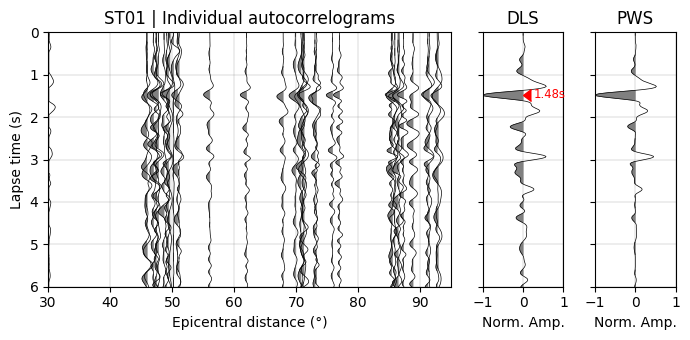

In [9]:
from obspy.core import Stream

def main_autocorrelation(dstream, freq_width=0.5, npts=60*40, taper_width=0.5, pws_order=1,
                         filter_kw={'freqmin':1.0, 'freqmax':5.0, 'corners':4, 'zerophase':True}):
    """
    Compute the autocorrelation function for the given stream.
    
    dstream: input stream of data
    freq_width: spectral whitening width
    npts: number of points for the autocorrelation function
    """
    ## Compute autocorrelograms for all downloaded data
    auto_stream = Stream()
    for tr in dstream.copy():
        auto = compute_auto(tr, freq_width=freq_width, npts=npts, taper_width=taper_width, 
                            filter_kwargs=filter_kw) 
        auto_stream.append(auto)
    ## Data linear stack (DLS)
    dls = data_stack(auto_stream, 0)
    ## Phase weighted stack (PWS) of order 1
    pws = data_stack(auto_stream, pws_order)
    ## Time vector for plotting
    tvec = np.arange(dls.stats.npts) * dls.stats.delta
    ## Pick the reflection time
    t_2p = tvec[np.argmin(dls.data[tvec<6])]

    ## Create a figure for plotting
    fig, ax = plt.subplots(1, 3, figsize=(7, 3.5), sharey=True, width_ratios=[1, 0.2, 0.2])
    ## Plot individual autocorrelograms
    for tr in auto_stream:
        # normalize the individual autocorrelogram by its maximum value
        data = tr.data / np.max(np.abs(tr.data))
        dist = tr.stats.dist / 111.195
        # plot the waveform using its trace index in the stream as the x-axis
        ax[0].plot(data+dist, tvec, lw=0.5, color='black')
        # fill the negative part of the waveform with gray color
        ax[0].fill_betweenx(tvec, dist, data+dist, lw=0.5, color='gray', where=(data < 0))
    ax[0].set(ylim=(6, 0), ylabel='Lapse time (s)', xlabel='Epicentral distance (°)', 
              title=f'{dstream[0].stats.station} | Individual autocorrelograms')
    ax[0].set(xlim=(30, 95))
    ## Plot the DLS
    dls.data /= np.max(np.abs(dls.data))
    ax[1].plot(dls.data, tvec, lw=0.5, color='black')
    ax[1].plot(0, t_2p, marker=4, c='r', ms=8)
    ax[1].text(0.25, t_2p, '%.2fs'%t_2p, color='r', va='center', fontsize='small')
    ax[1].fill_betweenx(tvec, 0, dls.data, lw=0.5, color='gray', where=(dls.data < 0))
    ax[1].set(xlim=(-1, 1), xlabel='Norm. Amp.', title='DLS')
    ## Plot the PWS
    pws.data /= np.max(np.abs(pws.data))
    ax[2].plot(pws.data, tvec, lw=0.5, color='black')
    ax[2].fill_betweenx(tvec, 0, pws.data, lw=0.5, color='gray', where=(pws.data < 0))
    ax[2].set(xlim=(-1, 1), xlabel='Norm. Amp.', title='PWS')
    ## Plot the grid
    for x in ax: x.grid(lw=0.2, color='gray')
    ## Adjust the layout
    fig.tight_layout()
    plt.show()

## evaluate the function to compute the autocorrelation
main_autocorrelation(dstream)

The delayed of the reflection peak of the ice-bedrock interface, $t_{2p}$, is about 1.5 seconds. If taking the average *P*-wave speed, $v_p$, in ice is about 3.9 km/s, the estimate ice thickness beneath this station is:
$$
H \approx \dfrac{t_{2p}v_p}{2} = 2.9\; \text{km}.
$$

In the practical excercises, we will look at the autocorrelograms along a line of seismic stations and compare with ice thickness obtained from other method.

---
## Challenge

Now, let take a little challenge by applying the processing presented above for a new seismic station. You are welcome to pick any station listed in the Table 1 in this paper (Pham & Tkalcic, [2018](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JB016115)) and compare the P-wave reflection time with the published result. 

A couple of ideas to experiment with your new dataset:
- Change the `minmagnitude=6.0`
- Change the spectral whitening width `freq_width=0.5`

Once finished, submit you result to the google sheet below. We will see the collective effort comparing the ice thickness estimated from passive seismology and radio-echo sounding!

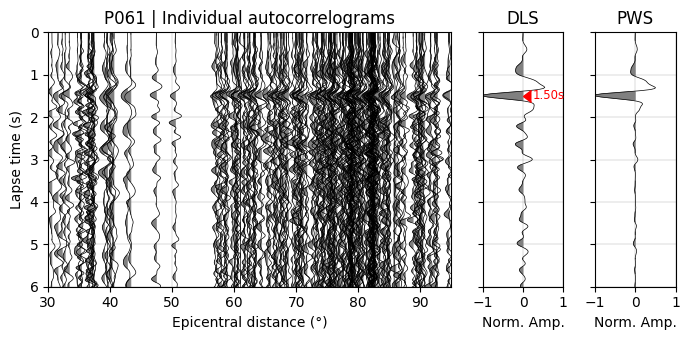

In [10]:
## Enter a station code (in Antarctica) of your choise
stacode0 = 'P061'

## Reminder of default parameters / Experiment with different values for the best outcome
freq_width = 0.5
npts = 60*40
taper_width = 0.5
pws_order = 1
filter_kw = {'freqmin':1.0, 'freqmax':5.0, 'corners':4, 'zerophase':True}
minmagnitude = 6.0

## find station and download vertical P-wave coda seismograms
inv0 = iris.get_stations(network='_ANTARCTICA', station=stacode0, channel='?HZ', level='channel')
# set bulk_size to None to download all available data of the station
dstream0 = download_data(inv0, bulk_size=300, min_magnitude=minmagnitude)
# autocorrelation processing
main_autocorrelation(dstream0, freq_width=freq_width, npts=npts, taper_width=taper_width, pws_order=pws_order, filter_kw=filter_kw)

Please enter your result to [Google Sheets](https://docs.google.com/spreadsheets/d/1MBMjAe-diJ1rlQqDpgsq-veorJL0i0pBzrC5uUgOViY/edit?usp=sharing)